In [79]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
from blank import *
from sampling import Sampler
from config_utils import parse_cfg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def display(img):
    return Image.fromarray(img)

In [82]:
def place_above(blank, num, dot_coords):

    top_left_row = dot_coords['min_row'] - num.shape[0] - random.randint(0, 10)
    top_left_col = dot_coords['min_col'] + random.randint(-20, 20)
    
    return blank.place_object(num, (top_left_row, top_left_col))

def place_below(blank, num, dot_coords):
        
    top_left_row = dot_coords['max_row'] + random.randint(0, 10)
    top_left_col = dot_coords['min_col'] + random.randint(-20, 20)
    
    return blank.place_object(num, (top_left_row, top_left_col))

def place_right(blank, num, dot_coords):
    
    top_left_row = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_col = dot_coords['max_col'] + random.randint(0, 10)
    
    return blank.place_object(num, (top_left_row, top_left_col))

def place_left(blank, num, dot_coords):
    
    top_left_row = dot_coords['min_row'] + random.randint(-20, 20)
    top_left_col = dot_coords['min_col'] - num.shape[1] - random.randint(0, 10)
    
    return blank.place_object(num, (top_left_row, top_left_col))

In [143]:
a = get_blanks('blanks')[2]
a.img = adaptive_thresh(a.img)

names, imgs, distr = get_img_data('nums')
num_sampler = Sampler(imgs, distr)

func = [place_above, place_below, place_left, place_right]

    
for i in range(30):
    dot = np.load('dots/dot1.npy')
    dot = adaptive_thresh(dot)
  #  dot = cv.resize(dot, (15,15))

    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    while not a.place_object(dot, (row, col)):
        row = random.randint(a.min_row, a.max_row)
        col = random.randint(a.min_col, a.max_col)
    
    # placed dot
    
    num = adaptive_thresh(num_sampler.get_sample())
  #  num = cv.resize(num, (15,15))

    top_left = row, col
    bot_right = row+dot.shape[0], col+dot.shape[1]
    
    dot_coords = {}
    dot_coords['min_row'] = top_left[0]
    dot_coords['max_row'] = bot_right[0]
    dot_coords['min_col'] = top_left[1]
    dot_coords['max_col'] = bot_right[1]

    np.random.shuffle(func)
    
    for f in func:
        if f(a, num, dot_coords):
            break
    

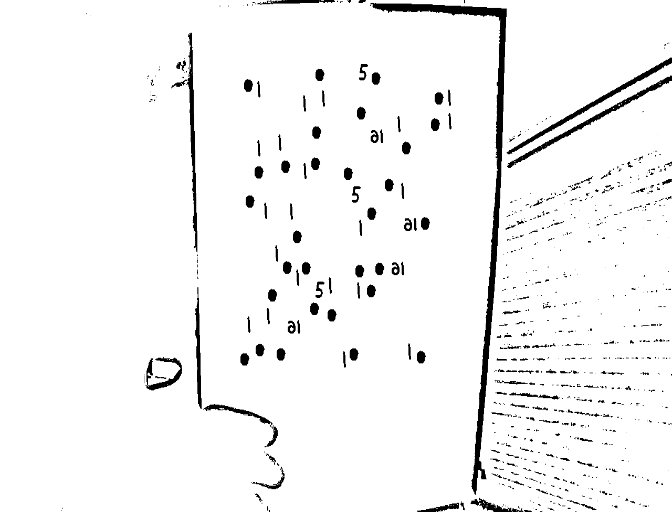

In [145]:
display(cv.resize(a.img, (672, 512)))

In [ ]:
# 864 x 512
# frist try 672 x 512